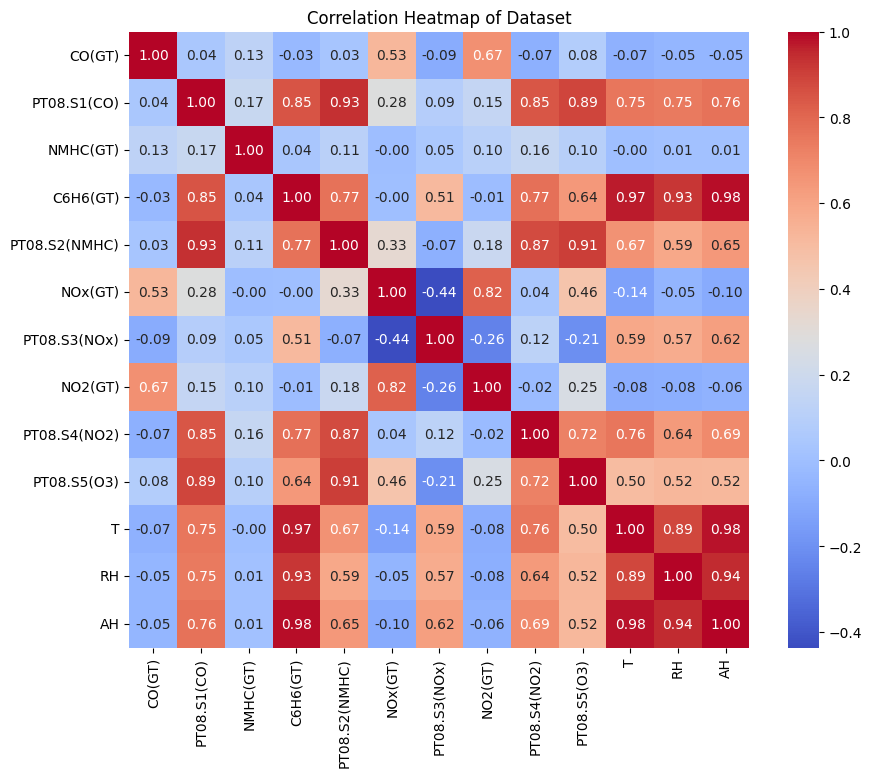


--- Random Forest Results ---
RMSE: 0.08825376193526599
R^2 Score: 0.9999953842503804


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1762.4413 - mse: 1762.4413 - val_loss: 1535.6687 - val_mse: 1535.6687
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1632.8473 - mse: 1632.8473 - val_loss: 1428.9187 - val_mse: 1428.9187
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1569.5419 - mse: 1569.5419 - val_loss: 1228.2644 - val_mse: 1228.2644
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1272.3193 - mse: 1272.3193 - val_loss: 967.8450 - val_mse: 967.8450
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 955.6544 - mse: 955.6544 - val_loss: 707.4891 - val_mse: 707.4891
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 664.8353 - mse: 664.8353 - val_loss: 487.4484 - val_mse: 487.4484
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 443.2260 - mse: 443.2260 - val_loss: 323.6980 - val_mse: 323.6980
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 300.3228 - mse: 300.3228 - val_loss: 215.085

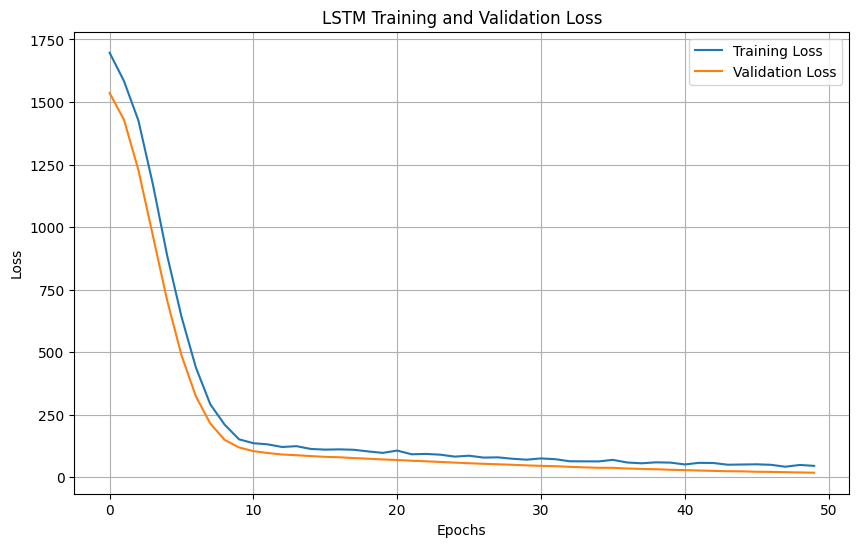

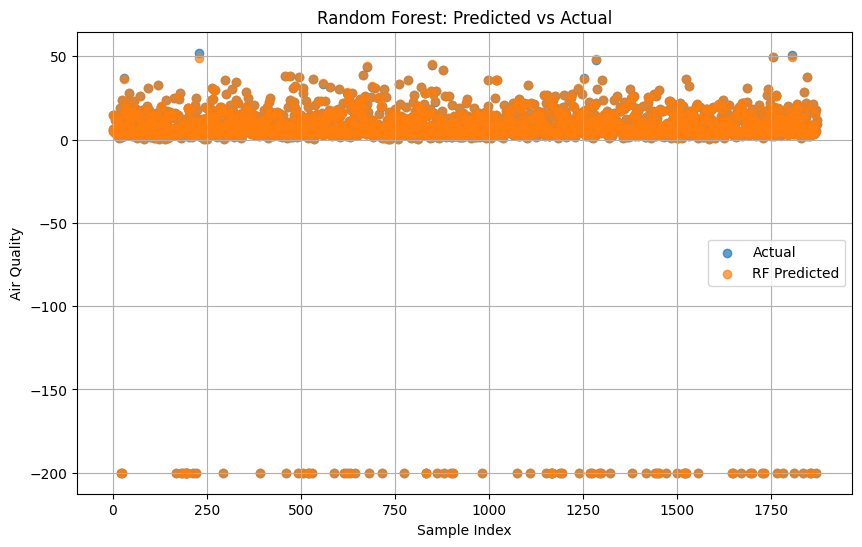

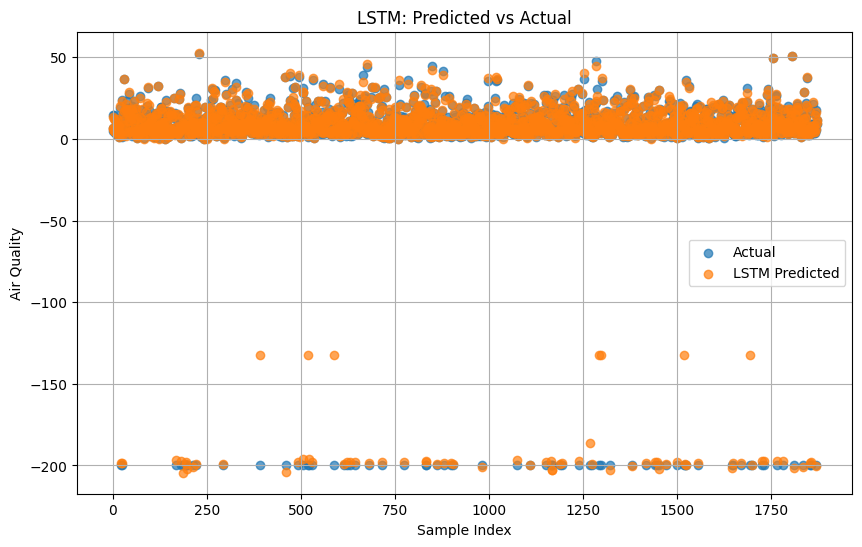

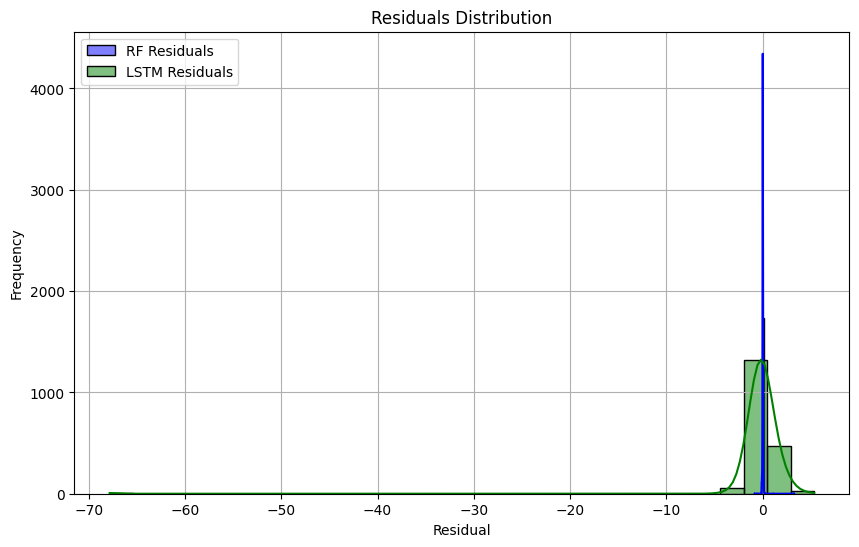

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load and preprocess the dataset
data_path = '/content/AirQuality.csv'  # Replace with the correct path
data = pd.read_csv(data_path, sep=';')

# Drop unnecessary columns
data.drop(['Date', 'Time', 'Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)

# Replace commas with dots and convert numeric columns to float
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].str.replace(',', '.').astype(float)

# Drop rows with missing values
data.dropna(inplace=True)

# Separate features (X) and target (y)
X = data.drop('C6H6(GT)', axis=1)
y = data['C6H6(GT)']

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=42)

# Visualize dataset using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Dataset')
plt.show()

### ---------------- Random Forest Model ---------------- ###
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using Random Forest
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Print Random Forest results
print("\n--- Random Forest Results ---")
print(f"RMSE: {rmse_rf}")
print(f"R^2 Score: {r2_rf}")

### ---------------- LSTM Model ---------------- ###
# Reshape data for LSTM
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Build LSTM model
lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.3),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train LSTM model
history = lstm_model.fit(
    X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1
)

# Predict using LSTM
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

# Evaluate LSTM
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
r2_lstm = r2_score(y_test, y_pred_lstm)

# Print LSTM results
print("\n--- LSTM Results ---")
print(f"RMSE: {rmse_lstm}")
print(f"R^2 Score: {r2_lstm}")

### ---------------- Visualization ---------------- ###
# Plot learning curves for LSTM
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot predictions for both models
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual', alpha=0.7)
plt.scatter(range(len(y_test)), y_pred_rf, label='RF Predicted', alpha=0.7)
plt.title('Random Forest: Predicted vs Actual')
plt.xlabel('Sample Index')
plt.ylabel('Air Quality')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='Actual', alpha=0.7)
plt.scatter(range(len(y_test)), y_pred_lstm, label='LSTM Predicted', alpha=0.7)
plt.title('LSTM: Predicted vs Actual')
plt.xlabel('Sample Index')
plt.ylabel('Air Quality')
plt.legend()
plt.grid()
plt.show()

# Confusion matrix (note: adapted for regression with residuals)
residuals_rf = y_test - y_pred_rf
residuals_lstm = y_test - y_pred_lstm

plt.figure(figsize=(10, 6))
sns.histplot(residuals_rf, kde=True, bins=30, label='RF Residuals', color='blue')
sns.histplot(residuals_lstm, kde=True, bins=30, label='LSTM Residuals', color='green')
plt.title('Residuals Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()


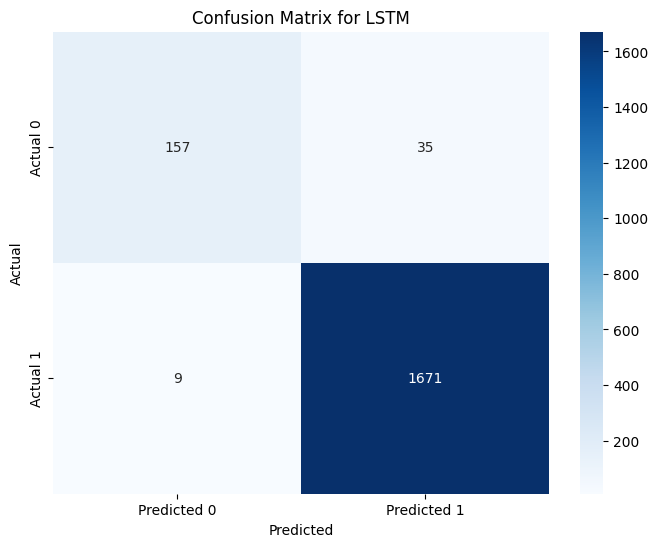

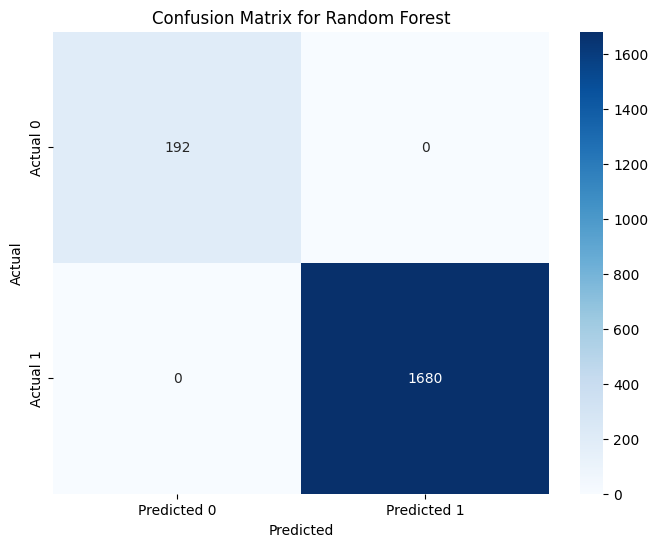

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Discretize predictions (example: threshold at the mean)
threshold = np.mean(y_test)
y_pred_lstm_class = np.where(y_pred_lstm > threshold, 1, 0)
y_pred_rf_class = np.where(y_pred_rf > threshold, 1, 0)
y_test_class = np.where(y_test > threshold, 1, 0)


# Confusion Matrix for LSTM
cm_lstm = confusion_matrix(y_test_class, y_pred_lstm_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test_class, y_pred_rf_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [8]:
print(f"LSTM Accuracy Score: {r2_lstm}")
print(f"Random Forest Accuracy Score: {r2_rf}")

LSTM Accuracy Score: 0.9890159006617785
Random Forest Accuracy Score: 0.9999953842503804


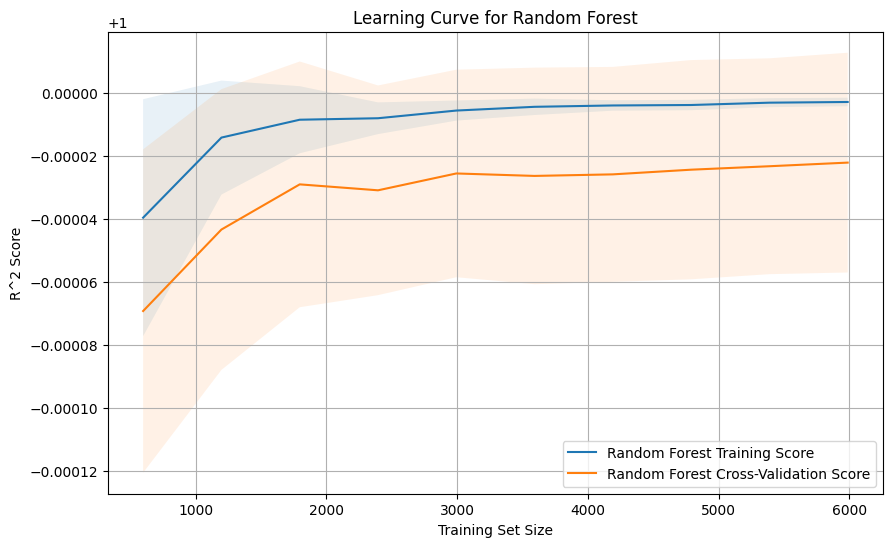

In [9]:
from sklearn.model_selection import learning_curve

# Learning Curve for Random Forest
train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(
    rf_model, X_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean_rf = np.mean(train_scores_rf, axis=1)
train_scores_std_rf = np.std(train_scores_rf, axis=1)
test_scores_mean_rf = np.mean(test_scores_rf, axis=1)
test_scores_std_rf = np.std(test_scores_rf, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes_rf, train_scores_mean_rf, label='Random Forest Training Score')
plt.fill_between(train_sizes_rf, train_scores_mean_rf - train_scores_std_rf,
                     train_scores_mean_rf + train_scores_std_rf, alpha=0.1)
plt.plot(train_sizes_rf, test_scores_mean_rf, label='Random Forest Cross-Validation Score')
plt.fill_between(train_sizes_rf, test_scores_mean_rf - test_scores_std_rf,
                     test_scores_mean_rf + test_scores_std_rf, alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curve for Random Forest')
plt.legend()
plt.grid()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


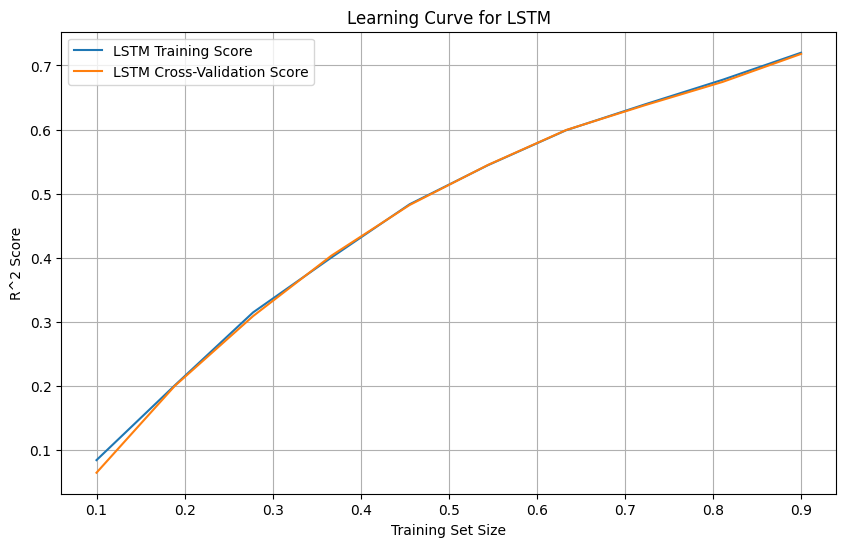

In [11]:
# Learning Curve for LSTM

train_sizes_lstm = np.linspace(0.1, 0.9, 10)
train_scores_lstm = []
test_scores_lstm = []

for train_size in train_sizes_lstm:
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=6)
    # X_train_subset is already a NumPy array, so directly reshape it
    X_train_subset_reshaped = X_train_subset.reshape(X_train_subset.shape[0], 1, X_train_subset.shape[1]) #Reshape data for LSTM

    lstm_model_subset = Sequential([
        LSTM(64, input_shape=(X_train_subset_reshaped.shape[1], X_train_subset_reshaped.shape[2])),
        Dropout(0.2),
        Dense(1)
    ])
    lstm_model_subset.compile(optimizer='adam', loss='mse')
    lstm_model_subset.fit(X_train_subset_reshaped, y_train_subset, epochs=10, verbose=0) # Reduced epochs for speed

    y_pred_lstm_train = lstm_model_subset.predict(X_train_subset_reshaped).flatten()
    train_scores_lstm.append(r2_score(y_train_subset, y_pred_lstm_train))

    X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1]) #Reshape data for LSTM
    y_pred_lstm_test = lstm_model_subset.predict(X_test_reshaped).flatten()
    test_scores_lstm.append(r2_score(y_test, y_pred_lstm_test))

#Plot learning curve for LSTM
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_lstm, train_scores_lstm, label='LSTM Training Score')
plt.plot(train_sizes_lstm, test_scores_lstm, label='LSTM Cross-Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('R^2 Score')
plt.title('Learning Curve for LSTM')
plt.legend()
plt.grid()
plt.show()